In [1]:
import os, sys
sys.path += [os.path.dirname('../scripts/')]

In [2]:
import pandas as pd
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
model_ckpt = 'non-CL'

In [5]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

# feature_extractor = ViTFeatureExtractor.from_pretrained('../outputs/' + model_ckpt + '/model')
# model = ViTForImageClassification.from_pretrained('../outputs/' + model_ckpt + '/model').to(device)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=64,
                                                  problem_type='regression',).to(device)

/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model

In [6]:
from torchaffectnet import AffectNetDataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor(),
    normalize,
])
valaro_dataset = AffectNetDataset('../../Affectnet/validation.csv',
                                  '../../Affectnet/Manually_Annotated/Manually_Annotated_Images/',
                                  transform=transform,
                                  mode='valence-arousal')
emotion_dataset = AffectNetDataset('../../Affectnet/validation.csv',
                                   '../../Affectnet/Manually_Annotated/Manually_Annotated_Images/',
                                   transform=transform,
                                   mode='classification')

In [7]:
from tqdm import tqdm
import numpy as np

def CLS_tokens(model, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device),
                          output_hidden_states=True).hidden_states[-1][0, 0, :]
        tokens.append(token.cpu())
        labels.append(label)
    tokens, labels = torch.stack(tokens).squeeze(), torch.stack(labels)
    data = np.column_stack((tokens, labels))
    np.savetxt(os.path.join(f'data/{model_ckpt}'+"token_and_valaro.csv"), data, delimiter=',')
    return tokens, labels


In [8]:
from typing import Literal
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from umap.umap_ import UMAP
from sklearn.manifold import MDS

class MinMaxScaler():
    def __init__(self, min_, max_, input_min, input_max):
        self.min = min_
        self.max = max_
        self.in_min = input_min
        self.in_max = input_max
    
    def transform(self, input):
        return (input - self.in_min) / (self.in_max - self.in_min) * (self.max - self.min) + self.min

def plot_tokens_valence(tokens, targets, n_neighbors, random_seed, method: Literal['umap', 'mds', 'csv'] = 'umap', csv_name: str = None):
    if method == 'umap':
        umap = UMAP(n_neighbors=n_neighbors, random_state=random_seed)
        zs = np.array(umap.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, targets.numpy()))
        np.savetxt(os.path.join(f'data/{model_ckpt}'+"valaro.csv"), data, delimiter=",")
        targets = targets.numpy()
    elif method == 'mds':
        mds = MDS(n_components=2, random_state=random_seed, n_init=2)
        tokens = F.normalize(tokens, dim=0)
        zs = np.array(mds.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, targets.numpy()))
        np.savetxt(os.path.join(f'data/{model_ckpt}'+"valaro.csv"), data, delimiter=",")
        targets = targets.numpy()
    elif method == 'csv':
        df = pd.read_csv(csv_name, header=None)
        cols = df.columns
        zs = df[cols[:2]].values
        targets = df[cols[2:]].values
    x = zs[:, 0]
    y = zs[:, 1]
    valence = targets[:, 0]
    arousal = targets[:, 1]
    # scaler = MinMaxScaler(25, 0.5, -1, 1)
    # size = scaler.transform(arousal)
    # alpha = (arousal - arousal.min()) / (arousal.max() - arousal.min())
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    ax.set_box_aspect(1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1,1)

    mp = ax.scatter(x, y,
                    alpha=0.6,
                    c=valence,
                    # c=arousal,
                    cmap='turbo',
                    vmin=-1,
                    vmax=1,
                    # s=size,
                    s=5,
                    edgecolors=None)
    color_bar = fig.colorbar(mp, ax=ax)
    color_bar.set_label('valence')
    return fig, None

def plot_tokens_arousal(tokens, targets, n_neighbors, random_seed, method: Literal['umap', 'mds', 'csv'] = 'umap', csv_name: str = None):
    if method == 'umap':
        umap = UMAP(n_neighbors=n_neighbors, random_state=random_seed)
        zs = np.array(umap.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, targets.numpy()))
        np.savetxt(os.path.join(f'data/{model_ckpt}'+"valaro.csv"), data, delimiter=",")
        targets = targets.numpy()
    elif method == 'mds':
        mds = MDS(n_components=2, random_state=random_seed, n_init=2)
        tokens = F.normalize(tokens, dim=0)
        zs = np.array(mds.fit_transform(tokens.numpy()))
        data = np.column_stack((zs, targets.numpy()))
        np.savetxt(os.path.join(f'data/{model_ckpt}'+"valaro.csv"), data, delimiter=",")
        targets = targets.numpy()
    elif method == 'csv':
        df = pd.read_csv(csv_name, header=None)
        cols = df.columns
        zs = df[cols[:2]].values
        targets = df[cols[2:]].values
    x = zs[:, 0]
    y = zs[:, 1]
    valence = targets[:, 0]
    arousal = targets[:, 1]
    # scaler = MinMaxScaler(25, 0.5, -1, 1)
    # size = scaler.transform(arousal)
    # alpha = (arousal - arousal.min()) / (arousal.max() - arousal.min())
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    ax.set_box_aspect(1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1,1)

    mp = ax.scatter(x, y,
                    alpha=0.6,
                    c=arousal,
                    # c=arousal,
                    cmap='turbo',
                    vmin=-1,
                    vmax=1,
                    # s=size,
                    s=5,
                    edgecolors=None)
    color_bar = fig.colorbar(mp, ax=ax)
    # color_bar.set_label('valence')
    color_bar.set_label('arousal')
    return fig, None

/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rk

100%|██████████| 4000/4000 [02:27<00:00, 27.04it/s]
/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


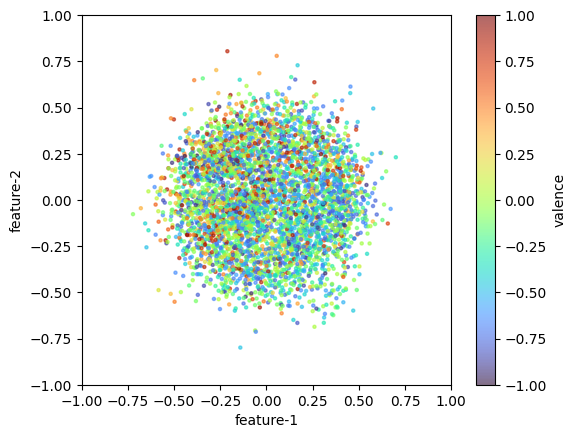

In [9]:
features, labels = CLS_tokens(model, valaro_dataset, device)
# fig, legend = plot_tokens_valence(None, None, 20, 0, 'csv', f'data/{model_ckpt}valaro.csv')
fig, legend = plot_tokens_valence(features, labels, 20, 0, 'mds', None)

In [10]:
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'valence'+'.svg'), bbox_inches='tight')
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'valence'+'.png'), bbox_inches='tight')

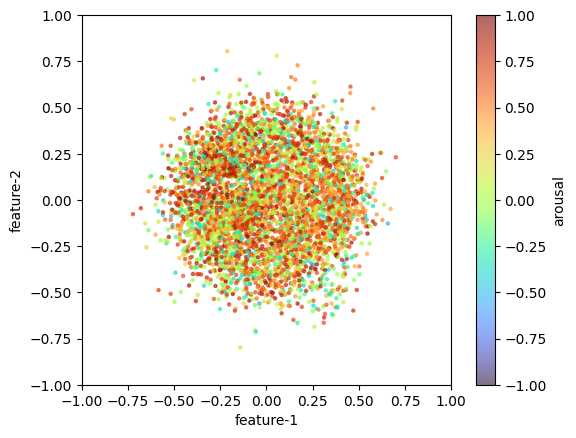

In [11]:
fig, legend = plot_tokens_arousal(None, None, 20, 0, 'csv', f'data/{model_ckpt}valaro.csv')

In [12]:
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'arousal'+'.svg'), bbox_inches='tight')
fig.savefig(os.path.join(
                f'results/{model_ckpt}'+'arousal'+'.png'), bbox_inches='tight')